# Motivation

We have a simple linear regression model $$y = mx + b$$ and we are trying to predict the price of a house given  its square footage, the number of bathrooms, and the average price of its neighbors.

In [11]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

raw_data = pd.DataFrame({"Square Footage" : [1000, 1500, 2000, 4000],
                          "# Bathrooms" : [1,1,2,3],
                          "Avg Neighborhood Price" : [150, 250, 400, 550]})

targets = pd.Series([205, 250, 320, 600])

def predict_all(data, weights):
    return data.dot(weights)
    
def calc_RSS(predictions):
    return pd.Series.sum((targets - predictions)**2)

def log_RSS(data, weights):
    return max(0,math.log(calc_RSS(predict_all(data,weights))))

def pred_vs_expect(preds):
    return pd.DataFrame({"predictions" : preds, "target" : targets})


norm_data = (raw_data - raw_data.mean()) / raw_data.std()
norm_data['Bias'] = 1

raw_data['Bias'] = 1

display(norm_data)

raw_data

,Square Footage,# Bathrooms,Avg Neighborhood Price,Bias
0,-0.855528,-0.783349,-1.071429,1
1,-0.475293,-0.783349,-0.500000,1
2,-0.095059,0.261116,0.357143,1
3,1.425880,1.305582,1.214286,1


,Square Footage,# Bathrooms,Avg Neighborhood Price,Bias
0,1000,1,150,1
1,1500,1,250,1
2,2000,2,400,1
3,4000,3,550,1


# Random Updates

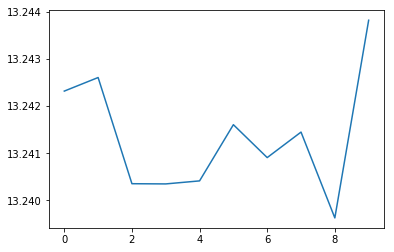

In [134]:
import random

def rupdate():
    return [random.random(),random.random(),random.random(),random.random()]

# try with random weights
weights = np.array([0.1,0.5,0.4,0.1])

updates = [rupdate() for _ in range(10)] #repeat, I miss thee but no more imports for me

# plot log error vs iteration (random weight updates)
plt.plot([log_RSS(norm_data,weights + w_update) for w_update in updates])

plt.show()

# Gradient Descent

Obviously, random weight updates is simply infeasible since our weights are continuous numbers.

So how can we update the weights so as to ensure convergence (ideally in a timely manner)?

Enter the gradient from left of stage

__TODO__ _replace verbiage below with an amazing analogy, and graphics, that will allow everyone in the audience to gain intuition about gradients with less than 1 minute of exposure_

The gradient of a (multivariate) function is a vector of the partial derivatives of that function with respect to each variable.  What we care about is the fact that at any point __X&#173;__ , the gradient of our function at point __X&#173;__ is the direction of greatest change in the function.  Proving this is beyond the scope of this presentation but we can maybe get some intuition by thinking about the following 2 points:

- In Euclidean space, the shortest distance between two points is a straight line.  The shortest distance between 2 contour lines (assuming a manifold surface ... and therefore local Euclidean space) will be perpendicular to the first contour line.


<img src="https://www.researchgate.net/profile/Sumanth_Chennupati/publication/312935261/figure/fig11/AS:454802724397077@1485444827591/Illustration-of-gradient-descent-algorithm-where-steps-are-taken-from-x0-to-x4-in-the.png" alt="Gradient and Contour lines" title="Gradient and Contour lines" />
https://www.researchgate.net/figure/Illustration-of-gradient-descent-algorithm-where-steps-are-taken-from-x0-to-x4-in-the_fig11_312935261


- The gradient of a function at point __X&#173;__ is always orthogonal to the level curve (contour line) at that point. https://ocw.mit.edu/courses/mathematics/18-02sc-multivariable-calculus-fall-2010/2.-partial-derivatives/part-b-chain-rule-gradient-and-directional-derivatives/session-36-proof/MIT18_02SC_notes_19.pdf


So how can we use the gradient to update our weights?

First, let us express our loss function as a function of our model parameters (the weights), __w&#173;__.  

$$ L = \sum(label_i - prediction_i)^2  = \sum (label_i - wx_i)^2 $$

Note that I am using wx instead of mx + b but we see how they are equivalent (add 1 element to w for b and add a corresponding 1 to each input vector).

Now, the _jth_ entry in the gradient of our loss function is:

$$ \frac{\partial L}{\partial w_j} \sum_i (label_i - wx_i)^2 = \frac{\partial L}{\partial w_j} \sum_i U^2 = \sum_i 2U \frac{\partial L}{\partial w_j}U = \sum_i 2(label_i - wx_i) \frac{\partial L}{\partial w_j}(label_i - wx_i)$$

$$= \sum_i -2x_{ij}(label_i - wx_i)$$ 

In [12]:
def batch_train(data,learning_rate, epochs):
    w = np.array([0.01,0.5,0.2,0.1])

    log_rssz = [log_RSS(data, w)]

    for x in range(epochs):
        errors = predict_all(norm_data,w) - targets
        w -= learning_rate * errors.dot(norm_data)
        log_rssz.append(log_RSS(data, w))
        
    return w,log_rssz

def show_it(data, trainer, lrates, epochs):
    # Set up a subplot grid that has height 2 and width 1,
    # and set the first such subplot as active.
    h = math.ceil(len(lrates) / 2.0)
    
    for i,learn_rate in enumerate(lrates):   
        plt.subplot(h, 2, i+1)  #activate the plot
        w, log_error = trainer(data, learn_rate, epochs)
           
        plt.plot(log_error)
        plt.title('Learning Rate: ' + str(learn_rate))
        plt.xlabel('Epochs')
        plt.ylabel('Log RSS')
        plt.axis([0, epochs, 0, 20])
        plt.tight_layout()
    
    return plt.show()

## Batch Training without normalizing data

,Square Footage,# Bathrooms,Avg Neighborhood Price,Bias
0,1000,1,150,1
1,1500,1,250,1
2,2000,2,400,1
3,4000,3,550,1


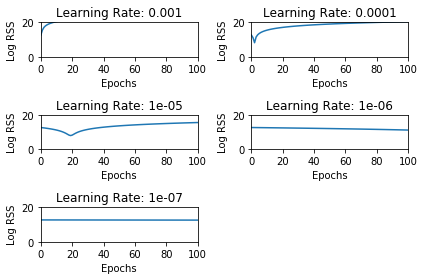

In [133]:
display(raw_data)

show_it(raw_data, batch_train, [0.001, 0.0001, 0.00001, 0.000001, 0.0000001], 100)

## Batch Training with Standardized Data

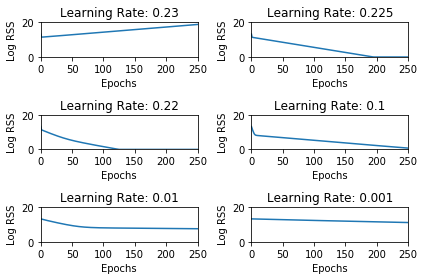

In [13]:
show_it(norm_data, batch_train, [0.23,0.225,0.22,0.1,0.01,0.001], 250)

## Stochastic Training

Can't fit the data set into memory

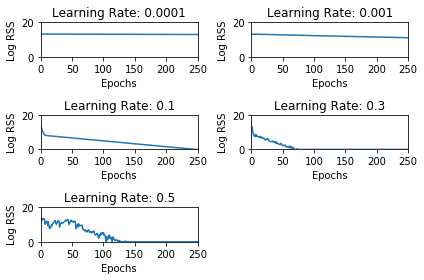

In [127]:
def stoch_train(data,lrate, epochs):
    w = np.array([0.01,0.5,0.2,0.1])

    log_rssz = [log_RSS(norm_data, w)]

    for x in range(epochs):
        data = norm_data.sample(frac=1)  #shuffle the data
    
        for i,ex in data.iterrows():
            err = targets[i] - ex.dot(w)
            w += lrate * (ex*err)
        
        log_rssz.append(log_RSS(norm_data, w)) #use norm data so that the targets line up with the objects
    
    return w,log_rssz


show_it(norm_data, stoch_train, [0.0001, 0.001, 0.1, 0.3, 0.5], 250)

## Mini-batch 

Left as an exercise for the reader

##  Backpropagation

How can we use gradient descent to learn the weights of a multilayer neural network?

https://en.wikipedia.org/wiki/Backpropagation

To show

- backprop
    - diminishing gradient (why use RELU vs sigmoid)